<a href="https://colab.research.google.com/github/cianadeveau/NeuroSAE/blob/main/SAE_for_2p_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Autoencoder Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
datadir = Path('/content/drive/My Drive/Colab Notebooks/').expanduser()

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import einops
import random
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Read in brain data

In [5]:
path_to_data = 'datasets/dff_traces_movie.npy'
data = np.load(datadir/path_to_data, allow_pickle=True)

In [6]:
def data_load(data, nCells, nFrames, nTrials, split=0.7):
  data_reshaped = data.reshape(nCells, nTrials, nFrames)
  train = data_reshaped[:,:int(nTrials*split),:].reshape(nCells, -1)
  test = data_reshaped[:,int(nTrials*split):,:].reshape(nCells, -1)
  train_data_tensor = torch.tensor(train.T).float()
  test_data_tensor = torch.tensor(test.T).float()
  return train_data_tensor, test_data_tensor

In [7]:
nCells = data.shape[0]
nFrames = data.shape[2]
nTrials = data.shape[1]
train_data_tensor, test_data_tensor = data_load(data, nCells, nFrames, nTrials)

## AutoEncoder

In [150]:
# D = d_model, F = dictionary_size
# e.g. if d_model = 12288 and dictionary_size = 49152
# then model_activations_D.shape = (12288,) and encoder_DF.weight.shape = (12288, 49152)

class SparseAutoEncoder(nn.Module):
    """
    A one-layer autoencoder.
    """
    def __init__(self, activation_dim: int, embed_size: int):
        super().__init__()
        self.activation_dim = activation_dim
        self.embed_size = embed_size

        self.encoder_DF = nn.Linear(activation_dim, embed_size, bias=True)
        self.decoder_FD = nn.Linear(embed_size, activation_dim, bias=True)

    def encode(self, model_activations_D: torch.Tensor) -> torch.Tensor:
        return nn.ReLU()(self.encoder_DF(model_activations_D))

    def decode(self, encoded_representation_F: torch.Tensor) -> torch.Tensor:
        return self.decoder_FD(encoded_representation_F)

    def forward_pass(self, model_activations_D: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        encoded_representation_F = self.encode(model_activations_D)
        reconstructed_model_activations_D = self.decode(encoded_representation_F)
        return reconstructed_model_activations_D, encoded_representation_F

    def get_encoder_output(self, model_activations_D: torch.Tensor) -> torch.Tensor:
        """
        This method returns the output of the encoder, which is the last layer before decoding.
        """
        return self.encode(model_activations_D)

    def get_dencoder_output(self, model_activations_D: torch.Tensor) -> torch.Tensor:
        """
        This method returns the output of the decoder.
        """
        return self.dencode(self.encode(model_activations_D))

In [151]:
# B = batch size, D = d_model, F = dictionary_size

def calculate_loss(autoencoder: SparseAutoEncoder, model_activations_BD: torch.Tensor, l1_coefficient: float) -> torch.Tensor:
    reconstructed_model_activations_BD, encoded_representation_BF = autoencoder.forward_pass(model_activations_BD)
    reconstruction_error_BD = (reconstructed_model_activations_BD - model_activations_BD).pow(2)
    reconstruction_error_B = einops.reduce(reconstruction_error_BD, 'B D -> B', 'sum')
    l2_loss = reconstruction_error_B.mean()

    l1_loss = l1_coefficient * encoded_representation_BF.sum()
    loss = l2_loss + l1_loss
    return loss

In [152]:
def train_autoencoder(autoencoder, model_activations_BD, l1_coefficient, num_epochs, learning_rate):
  optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
  batch_size = 32
  for epoch in range(num_epochs):
    for i in range(0, len(model_activations_BD), batch_size):
      batch = model_activations_BD[i:i+batch_size]
      optimizer.zero_grad()
      loss = calculate_loss(autoencoder, batch, l1_coefficient)
      loss.backward()
      optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

## Train Model

In [153]:
autoencoder = SparseAutoEncoder(activation_dim=data.shape[0], embed_size=2000).to(device) # Most important parameter to change for training is embed_size
train_autoencoder(autoencoder, train_data_tensor.to(device), 0.0001, 300, 0.001)

Epoch 1, Loss: 1100.20556640625
Epoch 2, Loss: 890.3473510742188
Epoch 3, Loss: 629.2211303710938
Epoch 4, Loss: 735.8295288085938
Epoch 5, Loss: 1086.4566650390625
Epoch 6, Loss: 751.2261962890625
Epoch 7, Loss: 724.5419921875
Epoch 8, Loss: 871.1088256835938
Epoch 9, Loss: 892.6582641601562
Epoch 10, Loss: 646.9740600585938
Epoch 11, Loss: 781.2481689453125
Epoch 12, Loss: 1026.3262939453125
Epoch 13, Loss: 755.2651977539062
Epoch 14, Loss: 672.5462646484375
Epoch 15, Loss: 1021.3880615234375
Epoch 16, Loss: 810.0319213867188
Epoch 17, Loss: 685.39990234375
Epoch 18, Loss: 752.6754760742188
Epoch 19, Loss: 642.2642211914062
Epoch 20, Loss: 797.74755859375
Epoch 21, Loss: 576.1387329101562
Epoch 22, Loss: 661.4431762695312
Epoch 23, Loss: 820.731201171875
Epoch 24, Loss: 572.8027954101562
Epoch 25, Loss: 756.26220703125
Epoch 26, Loss: 832.6319580078125
Epoch 27, Loss: 595.6970825195312
Epoch 28, Loss: 671.4398193359375
Epoch 29, Loss: 700.234375
Epoch 30, Loss: 592.6591796875
Epoch 3

## Check Reconstructions

In [154]:
reconstructions, encoder_layer = autoencoder.forward_pass(train_data_tensor.to(device))
reconstructions = reconstructions.cpu().detach().numpy()

# np.save(datadir/'reconstructions_train.npy', reconstructions)

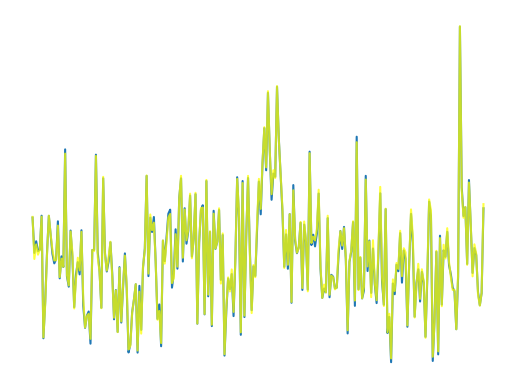

In [155]:
sample_num = reconstructions.shape[0] - nFrames
cell = 15
plt.plot(train_data_tensor.detach().numpy()[sample_num:,cell])
plt.plot(reconstructions[sample_num:,cell], color='yellow', alpha=0.75)

plt.axis('off')
plt.show()

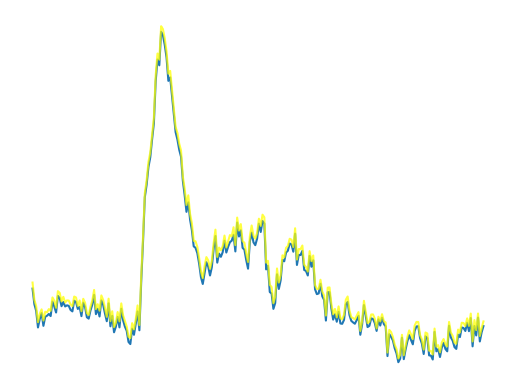

In [163]:
reshaped_reconstructions = reconstructions.T.reshape(nCells, int(reconstructions.shape[0]/nFrames), nFrames)
reshaped_train_tensor = train_data_tensor.detach().numpy().T.reshape(nCells, int(reconstructions.shape[0]/nFrames), nFrames)
plt.plot(reshaped_train_tensor.mean(axis=(0,1)))
plt.plot(reshaped_reconstructions.mean(axis=(0,1)), color='yellow', alpha=0.75)

plt.axis('off')
plt.show()

In [ ]:
# so the representation is reconstructed nicely - next look at the encoding layer per timepoint

In [164]:
reconstructions, encoder_layer = autoencoder.forward_pass(test_data_tensor.to(device))
reconstructions = reconstructions.cpu().detach().numpy()

# np.save(datadir/'reconstructions_test.npy', reconstructions)

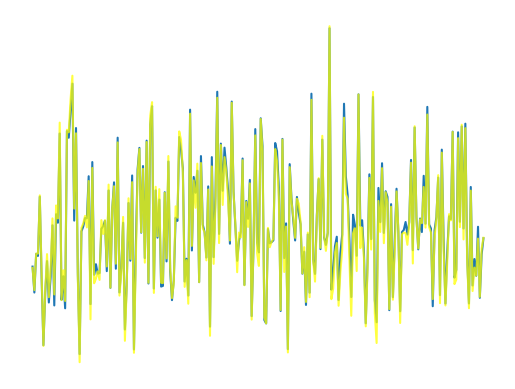

In [165]:
sample_num = reconstructions.shape[0] - nFrames
cell = 76
plt.plot(test_data_tensor.detach().numpy()[sample_num:,cell])
plt.plot(reconstructions[sample_num:,cell], color='yellow', alpha=0.75)

plt.axis('off')
plt.show()

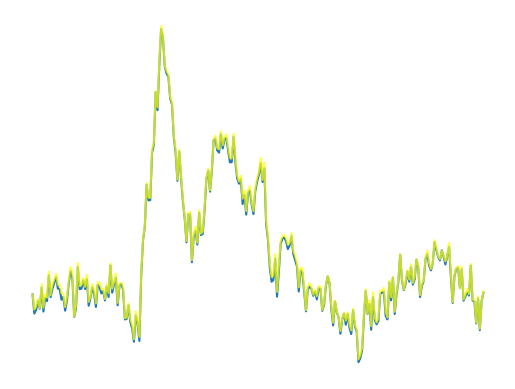

In [167]:
reshaped_reconstructions = reconstructions.T.reshape(nCells, int(reconstructions.shape[0]/nFrames), nFrames)
reshaped_test_tensor = test_data_tensor.detach().numpy().T.reshape(nCells, int(reconstructions.shape[0]/nFrames), nFrames)
plt.plot(reshaped_test_tensor.mean(axis=(0,1)))
plt.plot(reshaped_reconstructions.mean(axis=(0,1)), color='yellow', alpha=0.75)

plt.axis('off')
plt.show()

## Analyze Sparse Embeddings

Sparsity of activations: 92.03%


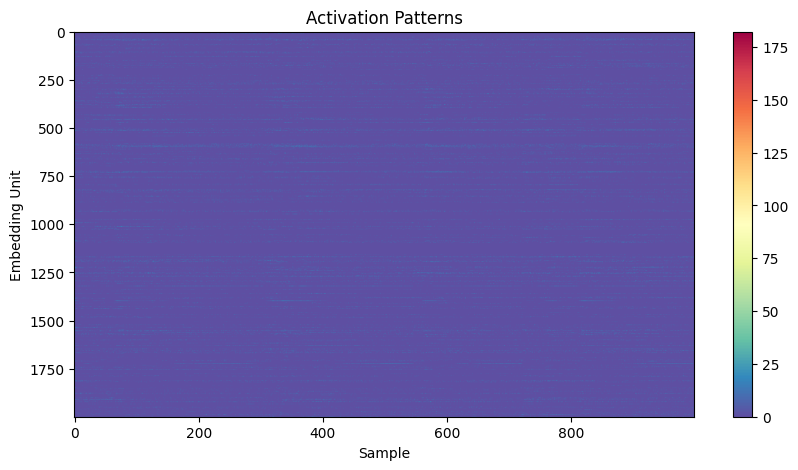

In [168]:
def analyze_sparsity(model, input_data):
    with torch.no_grad():
        activations = model.get_encoder_output(input_data)
    activations_np = activations.cpu().numpy()

    sparsity = np.mean(activations_np == 0)
    print(f"Sparsity of activations: {sparsity:.2%}")

    plt.figure(figsize=(10, 5))
    plt.imshow(activations_np[:1000].T, aspect='auto', cmap='Spectral_r')
    plt.colorbar()
    plt.title("Activation Patterns")
    plt.xlabel("Sample")
    plt.ylabel("Embedding Unit")
    plt.savefig(datadir/'sparsity2.png')
    plt.show()

# Generate some sample input data
analyze_sparsity(autoencoder, train_data_tensor.to(device))

In [169]:
def get_most_active_units(model, input_data, top_n=50):
    with torch.no_grad():
        activations = model.get_encoder_output(input_data)
    activations_np = activations.cpu().numpy()

    # Calculate average activation for each unit
    avg_activations = np.mean(activations_np, axis=0)

    # Get indices of top N most active units
    top_indices = np.argsort(avg_activations)[-top_n:][::-1]

    return top_indices, avg_activations[top_indices]

# Usage
input_data = train_data_tensor.to(device)
top_indices, top_activations = get_most_active_units(autoencoder, input_data, top_n=50)

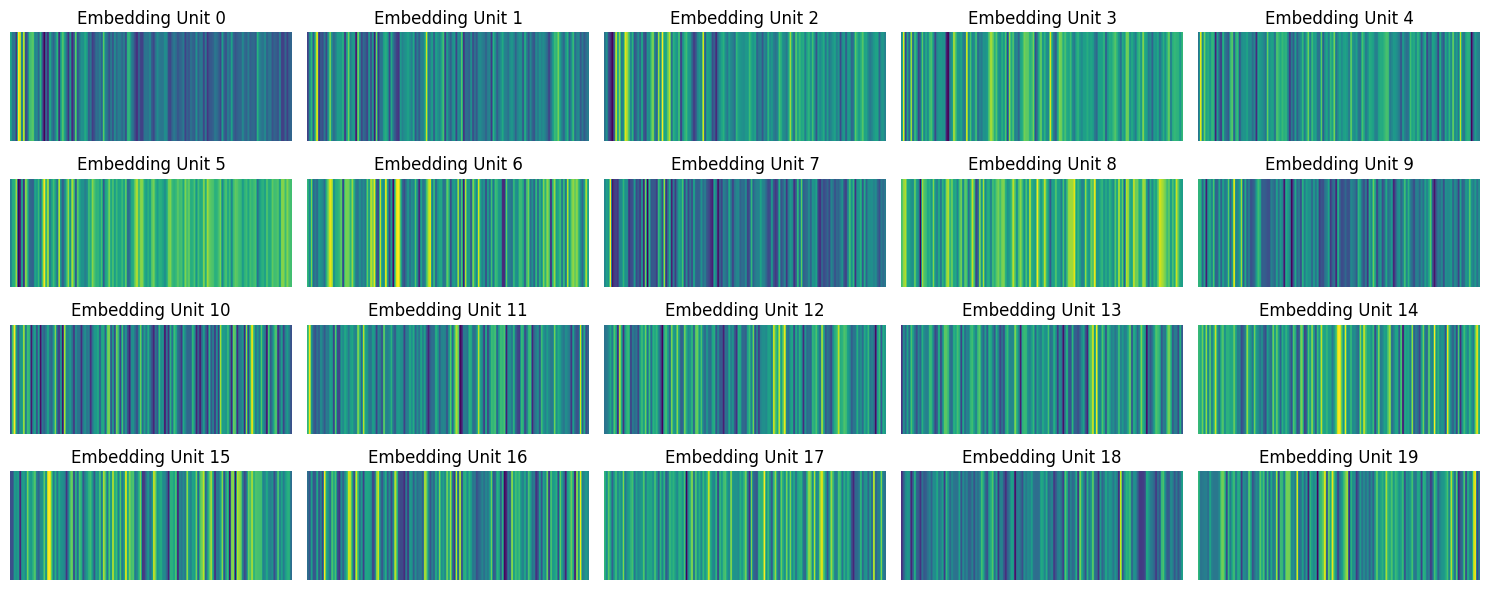

In [170]:
# Looking at the weights of the top active units
# Each column here is a weight associated with a single neuron
embedding_weights = autoencoder.encoder_DF.weight.data.cpu().numpy()
num_neurons = 20

fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(num_neurons):
    weights = embedding_weights[top_indices[i]]
    axes[i].imshow(weights.reshape((1, -1)), cmap='viridis', aspect='auto')
    axes[i].axis('off')
    axes[i].set_title(f"Embedding Unit {i}")

plt.tight_layout()
plt.show()

Top 50 active units: [1396 1319  726  593  357 1722 1270  312 1166 1225  825  125 1222   65
 1549  512  250 1932 1252   64   38 1025 1385 1909 1730 1204 1919 1336
 1169  282  540  508  817 1647  266  619 1660  852  450 1599 1788 1192
 1560 1664  172 1221  296  339 1056  674]
Their average activations: [12.250613  10.948276  10.34478    9.293391   8.112295   7.7696123
  7.139839   7.078619   6.585182   6.555525   6.478985   6.4510055
  6.4097223  6.398143   6.354933   6.169577   6.08958    6.068853
  6.0517817  6.0454597  6.0028286  5.994948   5.938389   5.919287
  5.8869705  5.864068   5.854891   5.850401   5.8485985  5.835033
  5.832248   5.7889013  5.7780194  5.7590537  5.715838   5.7048492
  5.704336   5.6791778  5.622991   5.6209545  5.6096435  5.6045113
  5.598797   5.590301   5.586108   5.569258   5.567948   5.566003
  5.539712   5.523969 ]


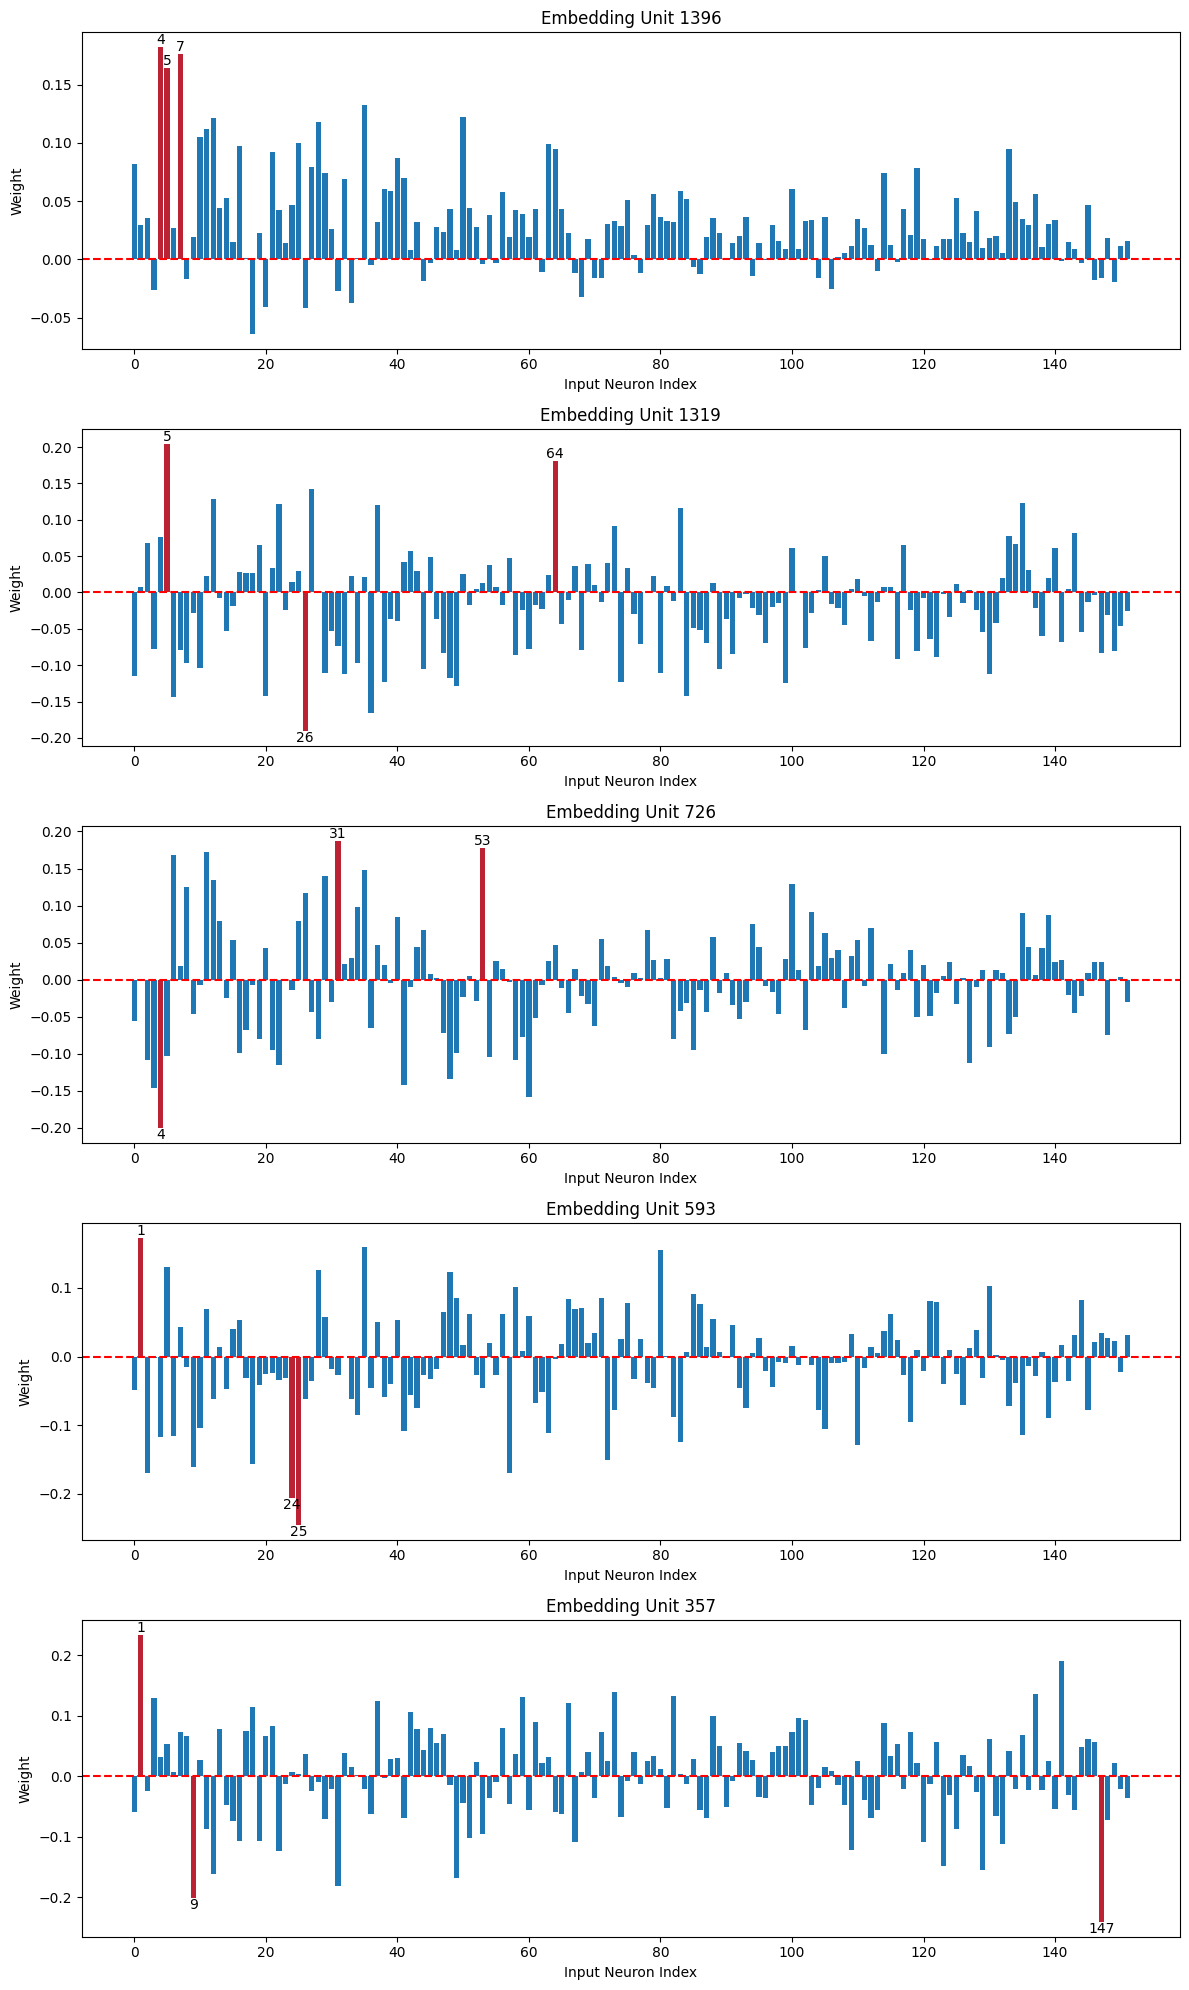

Embedding Unit 1396:
  1. Input neuron 4: weight = 0.1825
  2. Input neuron 7: weight = 0.1766
  3. Input neuron 5: weight = 0.1640

Embedding Unit 1319:
  1. Input neuron 5: weight = 0.2046
  2. Input neuron 26: weight = -0.1909
  3. Input neuron 64: weight = 0.1810

Embedding Unit 726:
  1. Input neuron 4: weight = -0.2008
  2. Input neuron 31: weight = 0.1875
  3. Input neuron 53: weight = 0.1771

Embedding Unit 593:
  1. Input neuron 25: weight = -0.2456
  2. Input neuron 24: weight = -0.2051
  3. Input neuron 1: weight = 0.1729

Embedding Unit 357:
  1. Input neuron 147: weight = -0.2415
  2. Input neuron 1: weight = 0.2336
  3. Input neuron 9: weight = -0.2011

Embedding Unit 1722:
  1. Input neuron 4: weight = -0.2271
  2. Input neuron 7: weight = -0.2026
  3. Input neuron 5: weight = -0.2001

Embedding Unit 1270:
  1. Input neuron 46: weight = -0.2024
  2. Input neuron 84: weight = -0.1904
  3. Input neuron 131: weight = -0.1756

Embedding Unit 312:
  1. Input neuron 3: weight 

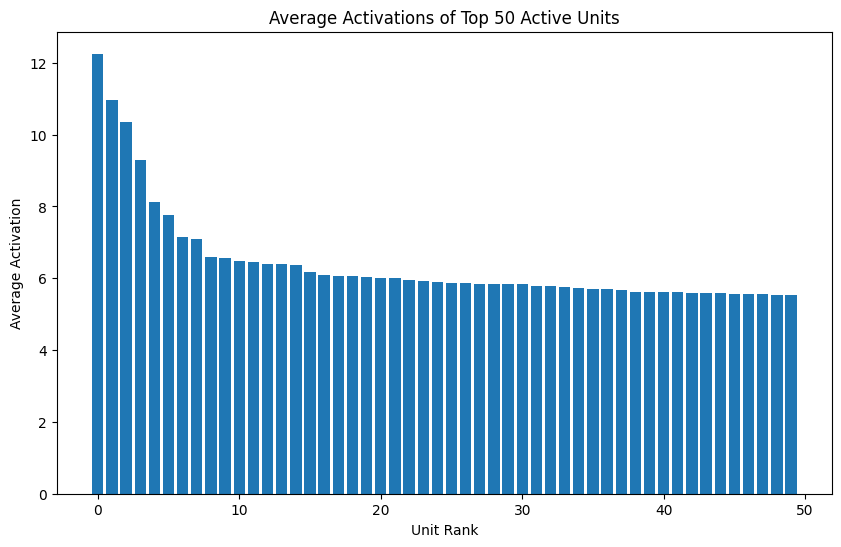

In [171]:
def identify_active_units(model, input_data, top_n=50):
    with torch.no_grad():
        activations = model.get_encoder_output(input_data)
    activations_np = activations.cpu().numpy()

    # Calculate the average activation for each unit
    avg_activations = np.mean(activations_np, axis=0)

    # Get the indices of the top N most active units
    active_units = np.argsort(avg_activations)[-top_n:][::-1]

    return active_units, avg_activations[active_units]


def extract_important_neurons(model, active_units, top_n=10):
    weights = model.encoder_DF.weight.data.cpu().numpy()

    important_neurons = {}
    for unit in active_units:
        unit_weights = weights[unit]
        top_neurons = np.argsort(np.abs(unit_weights))[-top_n:][::-1]
        important_neurons[unit] = list(zip(top_neurons, unit_weights[top_neurons]))

    return important_neurons

def visualize_important_neurons(model, important_neurons, n_units=5):
    weights = model.encoder_DF.weight.data.cpu().numpy()

    fig, axes = plt.subplots(n_units, 1, figsize=(12, 4*n_units))
    if n_units == 1:
        axes = [axes]

    for i, (unit, top_neurons) in enumerate(list(important_neurons.items())[:n_units]):
        unit_weights = weights[unit]
        axes[i].bar(range(nCells), unit_weights)
        axes[i].set_title(f"Embedding Unit {unit}")
        axes[i].set_xlabel("Input Neuron Index")
        axes[i].set_ylabel("Weight")
        axes[i].axhline(y=0, color='r', linestyle='--')

        for neuron, weight in top_neurons:
            axes[i].bar(neuron, weight, color='red', alpha=0.7)
            axes[i].text(neuron, weight, f'{neuron}', ha='center', va='bottom' if weight > 0 else 'top')

    plt.tight_layout()
    plt.show()

def print_important_neurons(important_neurons, n_units=10):
    for unit, neurons in list(important_neurons.items())[:n_units]:
        print(f"Embedding Unit {unit}:")
        for idx, (neuron, weight) in enumerate(neurons, 1):
            print(f"  {idx}. Input neuron {neuron}: weight = {weight:.4f}")
        print()

# Usage

input_data = train_data_tensor.to(device)

active_units, avg_activations = identify_active_units(autoencoder, input_data, top_n=50)
print(f"Top 50 active units: {active_units}")
print(f"Their average activations: {avg_activations}")

important_neurons = extract_important_neurons(autoencoder, active_units, top_n=3)

visualize_important_neurons(autoencoder, important_neurons, n_units=5)
print_important_neurons(important_neurons, n_units=50)

# Optionally, visualize the distribution of average activations
plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_activations)), avg_activations)
plt.title("Average Activations of Top 50 Active Units")
plt.xlabel("Unit Rank")
plt.ylabel("Average Activation")
plt.show()